In [10]:
import sys
sys.path.insert(0,'..')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [11]:
PATH = "/home/apil/data/fastai/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [12]:
resnet = arch(pretrained=True)

In [13]:
m = nn.Sequential(*children(resnet)[:-2],
                  nn.Conv2d(512, 2, 3, padding=1),
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.LogSoftmax())

In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [16]:
learn = ConvLearner.from_model_data(m,data)

In [17]:
learn.freeze_to(-4)

In [18]:
m[-1].trainable

True

In [19]:
m[-5].trainable

False

In [21]:
learn.fit(0.01,1)

Widget Javascript not detected.  It may not be installed or enabled properly.



  4%|▍         | 16/360 [00:03<00:55,  6.16it/s, loss=0.641]

 35%|███▌      | 127/360 [00:23<00:38,  5.98it/s, loss=0.154]


 70%|███████   | 253/360 [00:47<00:20,  5.20it/s, loss=0.139]


100%|█████████▉| 359/360 [01:07<00:00,  5.22it/s, loss=0.133]
                                                             [ 0.       0.13042  0.07815  0.98877]



In [22]:
learn.fit(0.01, 1, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.



 35%|███▍      | 125/360 [00:23<00:43,  5.35it/s, loss=0.114]


 69%|██████▉   | 249/360 [00:46<00:20,  5.53it/s, loss=0.0859]


100%|█████████▉| 359/360 [01:07<00:00,  5.39it/s, loss=0.067] 
                                                             [ 0.       0.06564  0.0769   0.98926]



## CAM

In [24]:
class SaveFeatures():
    features = None
    
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = to_np(output)
        
    def remove(self):
        self.hook.remove()

In [25]:
x,y = next(iter(data.val_dl))

In [26]:
print(x.shape)
print(y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [33]:
u,v = x[None,5], y[None,5]
print(u.shape)
print(v.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1])


In [34]:
vx = Variable(u.cuda(), requires_grad=True)
vx.size()

torch.Size([1, 3, 224, 224])

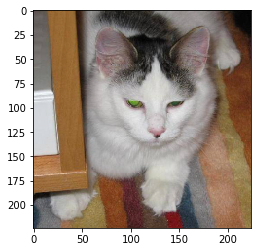

In [38]:
dx = data.val_ds.denorm(u)[0]
dx.shape
plt.imshow(dx)

In [84]:
layer_num = -4
sf = SaveFeatures(m[layer_num])

'''
run the model, which saves the features from m[layer_num]
'''
py = m(Variable(u.cuda()))

sf.remove()

In [85]:
'''
the following is simply a prediction between the dog-ness and cat-ness. Remember we have no softmax, so value 
not normalized between 0 and 1
'''
py

Variable containing:
  0.0000 -61.1928
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [86]:
'''
i don't really understand what/why this is being done...
but it feels like, this is effectively to null-ify one of the values
'''
py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [87]:
sf.features[0]

array([[[ 10.3929 ,  19.94411,  26.73205,  27.91206,  25.54515,  19.98521,  11.74359],
        [ 18.53168,  34.11056,  46.32193,  48.33543,  44.57502,  34.94184,  19.96528],
        [ 22.88233,  42.38388,  58.90023,  62.01381,  58.07795,  46.09967,  26.34131],
        [ 22.85132,  42.52208,  59.51332,  63.4994 ,  60.448  ,  47.68601,  26.72453],
        [ 20.31571,  36.28526,  49.7136 ,  52.13134,  48.46584,  36.99395,  20.20814],
        [ 14.9901 ,  25.79314,  33.26064,  33.85303,  29.80792,  21.50729,  10.5271 ],
        [  7.44667,  12.3392 ,  15.19648,  13.93806,  10.63111,   6.54492,   2.65627]],

       [[ -9.9872 , -19.1896 , -26.34335, -27.85479, -25.28834, -20.40711, -11.67282],
        [-16.63337, -32.51237, -45.48273, -47.68256, -43.97091, -34.4719 , -19.26649],
        [-21.25213, -40.27232, -56.86481, -59.81764, -56.599  , -44.21246, -24.31868],
        [-21.78281, -40.68106, -57.98218, -61.62733, -58.90548, -45.41028, -24.64657],
        [-19.23092, -34.6614 , -48.10933,

In [198]:
feat = sf.features[0]
print(feat.shape)
feat

(2, 7, 7)


array([[[ 10.3929 ,  19.94411,  26.73205,  27.91206,  25.54515,  19.98521,  11.74359],
        [ 18.53168,  34.11056,  46.32193,  48.33543,  44.57502,  34.94184,  19.96528],
        [ 22.88233,  42.38388,  58.90023,  62.01381,  58.07795,  46.09967,  26.34131],
        [ 22.85132,  42.52208,  59.51332,  63.4994 ,  60.448  ,  47.68601,  26.72453],
        [ 20.31571,  36.28526,  49.7136 ,  52.13134,  48.46584,  36.99395,  20.20814],
        [ 14.9901 ,  25.79314,  33.26064,  33.85303,  29.80792,  21.50729,  10.5271 ],
        [  7.44667,  12.3392 ,  15.19648,  13.93806,  10.63111,   6.54492,   2.65627]],

       [[ -9.9872 , -19.1896 , -26.34335, -27.85479, -25.28834, -20.40711, -11.67282],
        [-16.63337, -32.51237, -45.48273, -47.68256, -43.97091, -34.4719 , -19.26649],
        [-21.25213, -40.27232, -56.86481, -59.81764, -56.599  , -44.21246, -24.31868],
        [-21.78281, -40.68106, -57.98218, -61.62733, -58.90548, -45.41028, -24.64657],
        [-19.23092, -34.6614 , -48.10933,

In [199]:
'''
By default, script used 'rollaxis' but I couldn't understand the documentation
around it completely. So I used 'moveaxis', which I understand better. They
both seem to do the same thing...
'''

rolled = np.rollaxis(feat, 0, 3)
moved = np.moveaxis(feat, 0, 2)

np.array_equal(rolled, moved)

True

In [209]:
print(moved.shape)
moved

(7, 7, 2)


array([[[ 10.3929 ,  -9.9872 ],
        [ 19.94411, -19.1896 ],
        [ 26.73205, -26.34335],
        [ 27.91206, -27.85479],
        [ 25.54515, -25.28834],
        [ 19.98521, -20.40711],
        [ 11.74359, -11.67282]],

       [[ 18.53168, -16.63337],
        [ 34.11056, -32.51237],
        [ 46.32193, -45.48273],
        [ 48.33543, -47.68256],
        [ 44.57502, -43.97091],
        [ 34.94184, -34.4719 ],
        [ 19.96528, -19.26649]],

       [[ 22.88233, -21.25213],
        [ 42.38388, -40.27232],
        [ 58.90023, -56.86481],
        [ 62.01381, -59.81764],
        [ 58.07795, -56.599  ],
        [ 46.09967, -44.21246],
        [ 26.34131, -24.31868]],

       [[ 22.85132, -21.78281],
        [ 42.52208, -40.68106],
        [ 59.51332, -57.98218],
        [ 63.4994 , -61.62733],
        [ 60.448  , -58.90548],
        [ 47.68601, -45.41028],
        [ 26.72453, -24.64657]],

       [[ 20.31571, -19.23092],
        [ 36.28526, -34.6614 ],
        [ 49.7136 , -48.10933],


In [201]:
f2 = np.dot(moved, np.array([1.0, 0.]))

In [202]:
f2

array([[ 10.3929 ,  19.94411,  26.73205,  27.91206,  25.54515,  19.98521,  11.74359],
       [ 18.53168,  34.11056,  46.32193,  48.33543,  44.57502,  34.94184,  19.96528],
       [ 22.88233,  42.38388,  58.90023,  62.01381,  58.07795,  46.09967,  26.34131],
       [ 22.85132,  42.52208,  59.51332,  63.4994 ,  60.448  ,  47.68601,  26.72453],
       [ 20.31571,  36.28526,  49.7136 ,  52.13134,  48.46584,  36.99395,  20.20814],
       [ 14.9901 ,  25.79314,  33.26064,  33.85303,  29.80792,  21.50729,  10.5271 ],
       [  7.44667,  12.3392 ,  15.19648,  13.93806,  10.63111,   6.54492,   2.65627]])

In [203]:
f3 = np.dot(moved, np.array([0., 1.]))
f3

array([[ -9.9872 , -19.1896 , -26.34335, -27.85479, -25.28834, -20.40711, -11.67282],
       [-16.63337, -32.51237, -45.48273, -47.68256, -43.97091, -34.4719 , -19.26649],
       [-21.25213, -40.27232, -56.86481, -59.81764, -56.599  , -44.21246, -24.31868],
       [-21.78281, -40.68106, -57.98218, -61.62733, -58.90548, -45.41028, -24.64657],
       [-19.23092, -34.6614 , -48.10933, -50.57848, -46.9255 , -35.52027, -17.99844],
       [-14.11497, -24.3294 , -31.64142, -32.2583 , -28.13581, -19.63671,  -8.63906],
       [ -6.61274, -11.04788, -13.33846, -12.27276,  -9.21426,  -5.54517,  -1.91332]])

In [204]:
np.array_equal(f2, f3)

False

## Observation 1

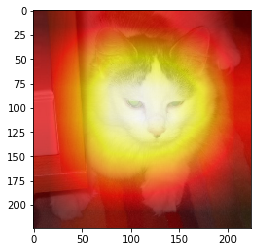

In [211]:
f2 -= f2.min()
f2 /= f2.max()

plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.7, cmap='hot')

## Observation 2

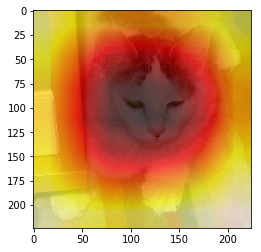

In [208]:
f3 -= f3.min()
f3 /= f3.max()

plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f3, dx.shape), alpha=0.7, cmap='hot')